# Statistics Project - Assignment 5

Gur Keinan, 213635899

Naomi Derel, 325324994

## Previous Assignments

We picked the "Cardiovascular Diseases Risk Prediction Dataset".

https://www.kaggle.com/datasets/alphiree/cardiovascular-diseases-risk-prediction-dataset?resource=download

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import bootstrap

np.random.seed(1012)

full_data = pd.read_csv('CVD_cleaned.csv')

# transformation 1:
full_data.loc[full_data["Diabetes"] ==
         'No, pre-diabetes or borderline diabetes', "Diabetes"] = 'at risk'
full_data = full_data[full_data["Diabetes"] != 'Yes, but female told only during pregnancy']

# transformation 2:
full_data["Numerical_Age_Category"] = full_data["Age_Category"].apply(
    lambda x: int(x[:2]))

### Additional transformation:
# transformation 3: min-max normalization to weight and height. they are on different scales and if we want to 
# use one to predict the other and get meaningful results, we need to normalize them to the same scale.
full_data["Weight_(kg)"] = (full_data["Weight_(kg)"] - full_data["Weight_(kg)"].min()) / \
    (full_data["Weight_(kg)"].max() - full_data["Weight_(kg)"].min())
full_data["Height_(cm)"] = (full_data["Height_(cm)"] - full_data["Height_(cm)"].min()) / \
    (full_data["Height_(cm)"].max() - full_data["Height_(cm)"].min())

## Part A -Bayesian Approach

**Research Question:** Does the distribution of weight differ between populations which do and don't exercise?


### 1.

In [168]:
# Sample independent groups of 200 and 1000 from the data:
n = 200
m = 1000

data = full_data[['Exercise', 'Weight_(kg)']]
observed_data = data.sample(n)
past_data = data.drop(observed_data.index).sample(m) # makes sure that the past data is not the same as the observed data

### 2.

In [169]:
theta = data['Weight_(kg)'].median()
print("theta = ", theta)

# create column Z as instructed:
def dichotomization(x):
    if x > theta:
        return 1
    else:
        return 0

observed_data['Z'] = observed_data['Weight_(kg)'].apply(dichotomization)
print(observed_data.head())

theta =  0.21151191852874252
       Exercise  Weight_(kg)  Z
102725      Yes     0.177640  0
195809       No     0.130264  0
65238       Yes     0.152274  0
167460      Yes     0.138732  0
295267      Yes     0.130264  0


#### 2.a.

$$ P(Z=1|Y=j) = \frac{P(Z=1, Y=j)}{P(Y=j)} $$

$$ \hat{P(Z=1|Y=j)} = \frac{ \# (Z=1 \& Y=j) / \#total}{\# Y=j / \#total} = \frac{ \# (Z=1 \& Y=j)}{\# Y=j} $$

In [170]:
# use the formula and the standard probability estimator (count of cases out of the total) to calculate p1 and p2:

observed_ex = observed_data[observed_data['Exercise'] == 'Yes']
observed_no_ex = observed_data[observed_data['Exercise'] == 'No']

num_ex = len(observed_ex)
num_z_ex = len(observed_ex[observed_ex['Z'] == 1])

num_no_ex = len(observed_no_ex)
num_z_no_ex = len(observed_no_ex[observed_no_ex['Z'] == 1])

p1 = num_z_ex / num_ex
p2 = num_z_no_ex / num_no_ex

print("p1 estimator = ", p1)
print("p2 estimator = ", p2)

p1 estimator =  0.45121951219512196
p2 estimator =  0.4166666666666667


In [171]:
# calculating the estimator for psi:

def nui(p):
    return np.log(p / (1 - p))

nui1 = nui(p1)
nui2 = nui(p2)

psi_a = nui1 - nui2
print("psi estimator = ", psi_a)

psi estimator =  0.14072765949511737


In [172]:
# calculating the CI for psi:

def find_psi(my_data):  
    ex = my_data[my_data['Exercise'] == 'Yes']
    no_ex = my_data[my_data['Exercise'] == 'No']

    num_ex = len(ex)
    num_z_ex = len(ex[ex['Z'] == 1])

    num_no_ex = len(no_ex)
    num_z_no_ex = len(no_ex[no_ex['Z'] == 1])

    my_p1 = num_z_ex / num_ex
    my_p2 = num_z_no_ex / num_no_ex

    return nui(my_p1) - nui(my_p2)

# bootstrap for psi:
B = 1000
bootstrap_psi = np.zeros(B)
for i in range(B):
    bootstrap_data = observed_data.sample(n, replace=True)
    psi_boot = find_psi(bootstrap_data)
    bootstrap_psi[i] = psi_boot
    
# calculating the quantile CI for psi:
psi_q1 = np.quantile(bootstrap_psi, 0.025)
psi_q2 = np.quantile(bootstrap_psi, 0.975)

ci_a = (psi_q1, psi_q2)
print("CI for psi = ", ci_a)

CI for psi =  (-0.5599775887506359, 0.9475619348193357)


#### 1.b.

We will use the example from the lecture on the Bayesian method, where we assume $Z_1, ..., Z_n $ ~ $Bernoulli(p)$ and a uniform prior. We showed that for a standard uniform prior, the posterior is $Beta(S+1, n-S+1)$ and therefore the posterior mean (and our estimator) is:

$$ \hat{p_j}= \frac{S_j+1}{n+2}$$

Where $S_j = \sum_{i=1}^n Z_i \cdot I(X_i = j)$.

In [173]:
S_est_ex = observed_ex['Z'].sum()
p1_est_b = (S_est_ex+1) / (num_ex+2)
print("p1 estimator = ", p1_est_b)

S_est_no_ex = observed_no_ex['Z'].sum()
p2_est_b = (S_est_no_ex+1) / (num_no_ex+2)
print("p2 estimator = ", p2_est_b)

psi_b = nui(p1_est_b) - nui(p2_est_b)
print("psi estimator = ", psi_b)

p1 estimator =  0.45180722891566266
p2 estimator =  0.42105263157894735
psi estimator =  0.12508233813799524


For calculating the CI, we will draw samples of size $n$ from the posterior distribution which we previously described and calculate the estimator of each sample, and then calculate the CI from those estimators.

In [174]:
boot_b = np.zeros(B)

# bootstrap for psi:
for i in range(B):
    p1_boot = stats.beta.rvs(S_est_ex+1, num_ex - S_est_ex + 1, size=1)
    p2_boot = stats.beta.rvs(S_est_no_ex+1, num_no_ex - S_est_no_ex + 1, size=1)
    psi_boot = nui(p1_boot) - nui(p2_boot)
    boot_b[i] = psi_boot

# calculating the quantile CI for psi:
boot_q1_b = np.quantile(boot_b, 0.025)
boot_q2_b = np.quantile(boot_b, 0.975)
ci_b = (boot_q1_b, boot_q2_b)
print("CI for psi = ", ci_b)

CI for psi =  (-0.5834566288827503, 0.8135241948302363)


#### 2.c.

Jeffery's prior is $\sqrt{I(\theta)}$ where $I(\theta)$ is the Fisher information. 

we saw in the lecture that for $Z_1, ..., Z_n $ ~ $Bernoulli(p)$, $I(\theta) = \frac{1}{p(1-p)}$. Therefore, the Jeffery's prior is $\sqrt{\frac{1}{p(1-p)}}$.

Now we can find the posterior distribution:
$ f(p|X^n) \propto p^S \cdot (1-p)^{n-S} \cdot \sqrt{\frac{1}{p(1-p)}} = p^{S-0.5} \cdot (1-p)^{n-S-0.5} = p^{(S+0.5)-1} \cdot (1-p)^{(n-S+0.5)-1}$ $\propto$ $Beta(S+0.5, n-S+0.5)$

Therefore, the posterior mean (and our estimator) is:
$ \hat{p} = E(p|X^n) = \frac{S+0.5}{n+1} $

In [175]:
p1_est_c = (S_est_ex+0.5) / (num_ex+1)
print("p1 estimator = ", p1_est_c)

p2_est_c = (S_est_no_ex+0.5) / (num_no_ex+1)
print("p2 estimator = ", p2_est_c)

psi_c = nui(p1_est_c) - nui(p2_est_c)
print("psi estimator = ", psi_c)

p1 estimator =  0.45151515151515154
p2 estimator =  0.4189189189189189
psi estimator =  0.13266218588804976


In [176]:
boot_c = np.zeros(B)

# bootstrap for psi:
for i in range(B):
    p1_boot = stats.beta.rvs(S_est_ex+0.5, num_ex - S_est_ex + 0.5, size=1)
    p2_boot = stats.beta.rvs(S_est_no_ex+0.5, num_no_ex - S_est_no_ex + 0.5, size=1)
    psi_boot = nui(p1_boot) - nui(p2_boot)
    boot_c[i] = psi_boot

# calculating the quantile CI for psi:
boot_q1_c = np.quantile(boot_c, 0.025)
boot_q2_c = np.quantile(boot_c, 0.975)
ci_c = (boot_q1_c, boot_q2_c)
print("CI for psi = ", ci_c)

CI for psi =  (-0.6165343798875534, 0.8807120108577076)


#### 2.d.

In [177]:
from scipy.stats import beta

# transform past data:
past_data['Z'] = past_data['Weight_(kg)'].apply(dichotomization)
past_ex = past_data[past_data['Exercise'] == 'Yes']
past_no_ex = past_data[past_data['Exercise'] == 'No']

# fit beta distribution to past data:
alpha1, beta1, _, _ = beta.fit(past_ex['Z'])
alpha2, beta2, _, _ = beta.fit(past_no_ex['Z'])

print("Exercise prior ~ Beta (", alpha1, ",", beta1, ")")
print("No exercise prior ~ Beta (", alpha2, ",", beta2, ")")


Exercise prior ~ Beta ( 1.5208561893855748 , 0.8363827207033676 )
No exercise prior ~ Beta ( 0.48501372682370125 , 0.16337575756491152 )


/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Like we saw in the HW for beta prior and binomial likelihood, he posterior distribution is:

$$ p_i | X^n \sim Beta(\alpha_i + S_i, \beta_i + n - S_i) $$

Therefore, the posterior mean (and our estimator) is:
$$ \hat{p_i} = \frac{\alpha_i + S_i}{\alpha_i + \beta_i + n} $$

In [178]:
p1_est_d = (S_est_ex + alpha1) / (num_ex + alpha1 + beta1)
print("p1 estimator = ", p1_est_d)

p2_est_d = (S_est_no_ex + alpha2) / (num_no_ex + alpha2 + beta2)
print("p2 estimator = ", p2_est_d)

psi_d = nui(p1_est_d) - nui(p2_est_d)
print("psi estimator = ", psi_d)

p1 estimator =  0.4539679588587204
p2 estimator =  0.42252917371498594
psi estimator =  0.1277483921558723


In [179]:
boot_d = np.zeros(B)

# bootstrap for psi:
for i in range(B):
    p1_boot = stats.beta.rvs(S_est_ex + alpha1, beta1 + num_ex - S_est_ex, size=1)
    p2_boot = stats.beta.rvs(S_est_no_ex + alpha2, beta2 + num_no_ex - S_est_no_ex, size=1)
    psi_boot = nui(p1_boot) - nui(p2_boot)
    boot_d[i] = psi_boot

# calculating the quantile CI for psi:
boot_q1_d = np.quantile(boot_d, 0.025)
boot_q2_d = np.quantile(boot_d, 0.975)
ci_d = (boot_q1_d, boot_q2_d)
print("CI for psi = ", ci_d)

CI for psi =  (-0.6045594786436314, 0.8682311999592438)


#### 2.e.

All the psi estimators are similar, and close to -0.21. The estimator based on past data is actually the most different, close to -0.25.

All the ci's are also quite similar, and contain zero. Therefore, based on the current data and exploration methods, we can't say that we found a significant difference between the two populations.

## Part B - Missing Data

**Research question:** Do changes in exercise (binary), sex (binary), and height (continuous), influence weight?

### 1.

In [180]:
# Get a sample of 1000 from the data:
N = 1000
dataB = full_data[['Exercise', 'Sex', 'Height_(cm)', 'Weight_(kg)']]
sample = dataB.sample(N)

# Transform categorical variables to numeric:
sex_values = sample['Sex'].apply(lambda x: 1 if x == 'Male' else 0)
exercise_values = sample['Exercise'].apply(lambda x: 1 if x == 'Yes' else 0)

# Create X matrix with a column of ones, and parameters:
x1 = np.concatenate((np.ones((N,1)), np.array(exercise_values).reshape(-1,1)), axis=1)
x2 = np.concatenate((x1, np.array(sex_values).reshape(-1,1)), axis=1)
X = np.concatenate((x2, np.array(sample.iloc[:, 2:3])), axis=1)

# Create y vector:
y = np.array(sample.iloc[:, 3]).reshape(-1,1)

In [181]:
# show there are no missing values:
print("Number of missing values in X: ", np.isnan(X).sum())
print("Number of missing values in y: ", np.isnan(y).sum())

Number of missing values in X:  0
Number of missing values in y:  0


### 2.

In [182]:
# Calculate the estimated coefficients from equation:
beta = np.linalg.inv(X.T @ X) @ X.T @ y
p = len(beta)

# Find normal estimated CI:
var_eps = (1/(N - p)) * np.sum((y - X @ beta)**2)
C = np.linalg.inv(X.T @ X)
se_beta = np.sqrt(var_eps * np.diag(C))
z_score = stats.norm.ppf(0.975)

ci_list_part2_lower = []
ci_list_part2_upper = []

for i, b in enumerate(beta):
    ci = (b - z_score * se_beta[i], b + z_score * se_beta[i])
    ci_list_part2_lower.append(ci[0][0])
    ci_list_part2_upper.append(ci[1][0])
    print(f"beta {i} = {b[0]:.4f}")
    print(f"beta {i} CI: ({ci[0][0]:.4f}, {ci[1][0]:.4f})")

beta 0 = -0.0553
beta 0 CI: (-0.0976, -0.0129)
beta 1 = -0.0337
beta 1 CI: (-0.0442, -0.0233)
beta 2 = 0.0017
beta 2 CI: (-0.0107, 0.0140)
beta 3 = 0.5645
beta 3 CI: (0.4774, 0.6516)


### 3.

We will delete the i-th largest y with a probability of $ p = \frac{i}{n} $, where $n$ is the number of observations.
This way, the larger the value of y the higher the probability of deleting it.

In [183]:
sorted_indices = np.argsort(y, axis=0)
new_y = y.copy()

for i in sorted_indices:
    p_i = i[0]/N
    ber_res = np.random.choice([0, 1], size=1, p=[1-p_i, p_i])
    if ber_res == 1:
        new_y[i] = None
    else:
        new_y[i] = y[i]

print("Number of missing values in new y: ", np.isnan(new_y).sum())

Number of missing values in new y:  512


### 4.

#### 4.a.

In [184]:
# Remove rows with missing values:
X_a = np.array([x for x, y in zip(X, new_y) if not np.isnan(y)])
y_a = np.array([y for x, y in zip(X, new_y) if not np.isnan(y)])
print(X_a.shape)
print(y_a.shape)

(488, 4)
(488, 1)


In [185]:
# Calculate the estimated coefficients from equation:
beta_a = np.linalg.inv(X_a.T @ X_a) @ X_a.T @ y_a
p = len(beta_a)
n_a = X_a.shape[0]

# Find normal estimated CI:
var_eps_a = (1/(n_a - p)) * np.sum((y_a - X_a @ beta_a)**2)
C_a = np.linalg.inv(X_a.T @ X_a)
se_beta_a = np.sqrt(var_eps_a * np.diag(C_a))
ci_list_a_lower = []
ci_list_a_upper = []

for i, b in enumerate(beta_a):
    ci = (b - z_score * se_beta_a[i], b + z_score * se_beta_a[i])
    ci_list_a_lower.append(ci[0][0])
    ci_list_a_upper.append(ci[1][0])
    print(f"beta {i} = {b[0]:.4f}")
    print(f"beta {i} CI: ({ci[0][0]:.4f}, {ci[1][0]:.4f})")

beta 0 = -0.0698
beta 0 CI: (-0.1290, -0.0106)
beta 1 = -0.0376
beta 1 CI: (-0.0524, -0.0227)
beta 2 = -0.0087
beta 2 CI: (-0.0268, 0.0095)
beta 3 = 0.6067
beta 3 CI: (0.4824, 0.7310)


#### 4.b.

In [186]:
# Complete the missing values with regression imputation:
y_b = new_y.copy()

for i in range(len(y_b)):
    yi = y_b[i]
    if np.isnan(yi):
        y_b[i] = X[i,:] @ beta_a

print("Number of missing values in y_b: ", np.isnan(y_b).sum())

Number of missing values in y_b:  0


In [187]:
# Calculate the estimated coefficients from equation:
beta_b = np.linalg.inv(X.T @ X) @ X.T @ y_b

# Find normal estimated CI:
var_eps_b = (1/(N - p)) * np.sum((y_b - X @ beta_b)**2)
C_b = np.linalg.inv(X.T @ X)
se_beta_b = np.sqrt(var_eps_b * np.diag(C_b))
ci_list_b_lower = []
ci_list_b_upper = []

for i, b in enumerate(beta_b):
    ci = (b - z_score * se_beta_b[i], b + z_score * se_beta_b[i])
    ci_list_b_lower.append(ci[0][0])
    ci_list_b_upper.append(ci[1][0])
    print(f"beta {i} = {b[0]:.4f}")
    print(f"beta {i} CI: ({ci[0][0]:.4f}, {ci[1][0]:.4f})")

beta 0 = -0.0698
beta 0 CI: (-0.0996, -0.0401)
beta 1 = -0.0376
beta 1 CI: (-0.0449, -0.0302)
beta 2 = -0.0087
beta 2 CI: (-0.0174, 0.0000)
beta 3 = 0.6067
beta 3 CI: (0.5455, 0.6679)


Notice the beta coefficients are identical to part a, because we used the model we predicted in part a on the existing data.

The CI's are smaller than in part a because we artificially created data and by doing so we reduced the variance.

#### 4.c.

In [188]:
# complete the missing values with multiple imputation:
M = 1000
boot_M = np.zeros((M, p))

var_c = (1/(N - p)) * np.sum((y_a - X_a @ beta_a)**2)
y_predicted = X @ beta_a

# for each iteration, draw a new y vector, such that each entry is drawn from a normal distribution with its predicted y and the variance of the residuals.
for i in range(M):
    y_temp = stats.norm.rvs(loc=y_predicted, scale=var_c)
    beta_temp = np.linalg.inv(X.T @ X) @ X.T @ y_temp
    boot_M[i,:] = beta_temp.reshape(-1)
    
beta_c = np.mean(boot_M, axis=0)
for i, b in enumerate(beta_c):
    print(f"beta {i} = {b:.4f}")


beta 0 = -0.0698
beta 1 = -0.0376
beta 2 = -0.0087
beta 3 = 0.6066


#### 4.d.

In [189]:
C_c = np.linalg.inv(X.T @ X)
se_beta_c = np.sqrt(var_c * np.diag(C_c))

# using the rubin formula:
var_d = np.mean(se_beta_c) + (M+1)/(M*(M-1)) * np.sum((boot_M - beta_c)**2, axis=0)
se_beta_d = np.sqrt(var_d)
print(se_beta_d)

# Find normal estimated CI:
ci_list_d_lower = []
ci_list_d_upper = []

for i, b in enumerate(beta_c):
    ci = (b - z_score * se_beta_d[i], b + z_score * se_beta_d[i])
    ci_list_d_lower.append(ci[0])
    ci_list_d_upper.append(ci[1])
    print(f"beta {i} = {b:.4f}")
    print(f"beta {i} CI: ({ci[0]:.4f}, {ci[1]:.4f})")

[0.11680789 0.11680577 0.11680581 0.11681529]
beta 0 = -0.0698
beta 0 CI: (-0.2987, 0.1592)
beta 1 = -0.0376
beta 1 CI: (-0.2665, 0.1914)
beta 2 = -0.0087
beta 2 CI: (-0.2376, 0.2203)
beta 3 = 0.6066
beta 3 CI: (0.3777, 0.8356)


#### 4.e.

In [190]:
from sklearn.linear_model import LogisticRegression

# define R indicator for missing values:
R = np.array([0 if np.isnan(new_y) else 1 for new_y in new_y]).reshape(-1,1)

# fit logistic regression model:
clf = LogisticRegression().fit(X, R.ravel())
R_pred = clf.predict_proba(X)

# show results:
df_res_e = pd.DataFrame({'True R': R.ravel(), 'R=0 pred': R_pred[:,0], 'R=1 pred': R_pred[:,1]})
print(df_res_e.sample(10))

     True R  R=0 pred  R=1 pred
862       0  0.526513  0.473487
691       0  0.526513  0.473487
679       0  0.478668  0.521332
455       0  0.476597  0.523403
49        1  0.524442  0.475558
634       1  0.476995  0.523005
504       0  0.484196  0.515804
865       0  0.528184  0.471816
285       0  0.512697  0.487303
205       1  0.515754  0.484246


#### 4.f.

The linear regression problem as a minimization problem is:
$$ \min_{\beta} \sum_{i=1}^n R_i \cdot (y_i - \beta^T x_i)^2 $$

Using Inverse Probability Weighting, we get:
$$ \min_{\beta} \sum_{i=1}^n \frac{R_i}{\pi(X)} \cdot (y_i - \beta^T x_i)^2 $$

where $\pi(X) = P(R=1|X)$.


In [191]:
from sklearn.linear_model import LinearRegression

# solve the minimization problem using linear regression:
r1_indices = df_res_e[df_res_e['True R'] == 1].index
pi_x = df_res_e['R=1 pred'][r1_indices]

linear_model = LinearRegression(fit_intercept=False).fit(X_a, y_a, 1/pi_x)

beta_f = linear_model.coef_[0]
for i, b in enumerate(beta_f):
    print(f"beta {i} = {b:.4f}")

beta 0 = -0.0708
beta 1 = -0.0375
beta 2 = -0.0088
beta 3 = 0.6086


#### 4.g.

In [192]:
boot_g = np.zeros((M, p))

# bootstrap for beta with IPW:
for i in range(B):
    indices = np.random.choice(new_y.shape[0], size=len(new_y), replace=True)
    X_temp = np.array([x for x, y in zip(X[indices], new_y[indices]) if not np.isnan(y)])
    y_temp = np.array([y for y in new_y[indices] if not np.isnan(y)])
    R_pred = clf.predict_proba(X_temp)

    linear_model = LinearRegression(fit_intercept=False).fit(X_temp, y_temp, 1/R_pred[:,1])
    beta_temp = linear_model.coef_[0]
    boot_g[i,:] = beta_temp.reshape(-1)

# calculating the quantile CI for beta:
beta_g = np.mean(boot_g, axis=0)
quantile1_g = np.quantile(boot_g, 0.025, axis=0)
quantile2_g = np.quantile(boot_g, 0.975, axis=0)

for i, b in enumerate(beta_g):
    print(f"beta {i} = {b:.4f}")
    print(f"beta {i} CI: ({quantile1_g[i]:.4f}, {quantile2_g[i]:.4f})")

beta 0 = -0.0713
beta 0 CI: (-0.1271, -0.0188)
beta 1 = -0.0380
beta 1 CI: (-0.0567, -0.0206)
beta 2 = -0.0087
beta 2 CI: (-0.0279, 0.0105)
beta 3 = 0.6104
beta 3 CI: (0.4884, 0.7406)


#### 4.h.

**I)**

The results from question 2 are pretty similar to the results we got at question 4. 

The coefficients are mostly similar, and so are the CI's.

Our conclusion is that our assumed models are successful at capturing the nature of our data. Specifically, the linear regression model is successful at predicting the weight of a person based on the other features.

**II)**

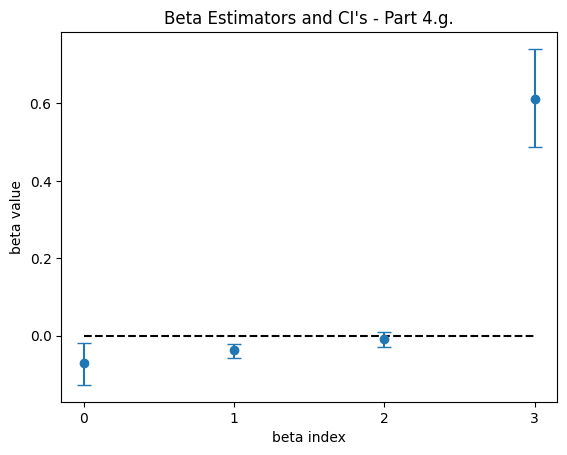

In [205]:
# show results for part g:
plt.errorbar(range(p), beta_g, yerr=[beta_g - quantile1_g, quantile2_g - beta_g], fmt='o', capsize=5)
plt.plot(range(p), np.zeros(p), 'k--')
plt.xticks(range(p)) 
plt.xlabel('beta index')
plt.ylabel('beta value')
plt.title("Beta Estimators and CI's - Part 4.g.")
plt.show()

We can see that for part g, $\beta_{0}, \beta_{1}, \beta_{3}$ are significant, and $\beta_{2}$ is not significant. 

**Full comparison:**

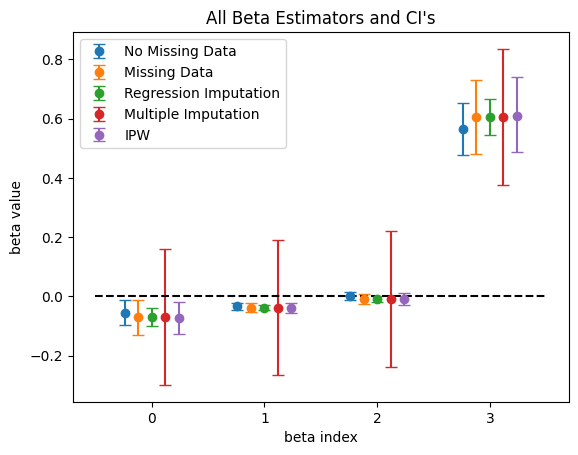

In [210]:
offset = 0.12
capsize = 4
plt.title("All Beta Estimators and CI's")

# part 2:
beta_plot = beta.reshape(-1)
plt.errorbar([x - 2*offset for x in range(p)], beta_plot, yerr=[beta_plot - ci_list_part2_lower, ci_list_part2_upper - beta_plot], fmt='o', capsize=capsize, label='No Missing Data')

# part 4.a:
beta_a_plot = beta_a.reshape(-1)
plt.errorbar([x - offset for x in range(p)], beta_a_plot, yerr=[beta_a_plot - ci_list_a_lower, ci_list_a_upper - beta_a_plot], fmt='o', capsize=capsize, label='Missing Data')

# part 4.b:
beta_b_plot = beta_b.reshape(-1)
plt.errorbar(range(p), beta_b_plot, yerr=[beta_b_plot - ci_list_b_lower, ci_list_b_upper - beta_b_plot], fmt='o', capsize=capsize, label='Regression Imputation')

# part 4.d:
beta_d_plot = beta_c.reshape(-1)
plt.errorbar([x + offset for x in range(p)], beta_d_plot, yerr=[beta_d_plot - ci_list_d_lower, ci_list_d_upper - beta_d_plot], fmt='o', capsize=capsize, label='Multiple Imputation')

# part 4.g.:
plt.errorbar([x + 2*offset for x in range(p)], beta_g, yerr=[beta_g - quantile1_g, quantile2_g - beta_g], fmt='o', capsize=capsize, label='IPW')

plt.plot([x+0.5 for x in range(-1, 4)], np.zeros(5), 'k--')

plt.xticks(range(p)) 
plt.xlabel('beta index')
plt.ylabel('beta value')
plt.legend()
plt.show()

We can see that the result are similar for all methods: 
* $\beta_{0}, \beta_{1}$ are usually significant, but closer to 0.
* $\beta_{2}$ is not significant and very close to zero. 
* $\beta_{3}$ is very significant.

The exception is the multiple impuation method that has very large CI's, so $\beta_{0}$ and $\beta_{1}$ are also not significant.